In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
from ast import literal_eval

main_song_df = pd.read_csv("spotify_songs.csv")
main_song_df = main_song_df.drop_duplicates(subset="track_id")
main_song_df = main_song_df.dropna()

stream_df = pd.read_csv("stream_data.csv", sep="#")
stream_df = stream_df.drop(columns=["Date", "Position"])

stream_df = stream_df.dropna()

stream_df["Genre"] = stream_df["Genre"].apply(literal_eval)

# Group by 'Track Name' and 'Artist', sum the 'Streams', and aggregate genres
stream_grouped = (
    stream_df.groupby(["Track Name", "Artist"])
    .agg(
        {
            "Streams": "sum",
            "Genre": lambda x: list(
                set([genre for sublist in x for genre in sublist])
            ),
        }
    )
    .reset_index()
)

print(stream_grouped)

stream_grouped.to_csv("merged_stream.csv")

                Track Name         Artist   Streams  \
0                        !   Trippie Redd   1969789   
1      #PROUDCATOWNERREMIX   XXXTENTACION    679370   
2       $$$ - with Matt Ox   XXXTENTACION   9889360   
3             $€ Freestyle  Sfera Ebbasta   1326336   
4         'Till I Collapse         Eminem  95904807   
...                    ...            ...       ...   
5669              Χ. ZWAAR          Damso    853905   
5670            Ψ. PASSION          Damso    906293   
5671       Ω. VIVRE UN PEU          Damso    783257   
5672  ‘tis the damn season   Taylor Swift  30159089   
5673                 美女と野獣  Ariana Grande  19608172   

                                                  Genre  
0                              [trap, melodic rap, rap]  
1                              [miami hip hop, emo rap]  
2                              [miami hip hop, emo rap]  
3         [trap italiana, italian hip hop, italian pop]  
4                       [rap, detroit hip hop, hi

In [25]:
sorted_stream_group = stream_grouped.sort_values("Streams", ascending=False)

sorted_stream_group

,Track Name,Artist,Streams,Genre
4173,Shape of You,Ed Sheeran,2736191812,"[pop, uk pop]"
643,Blinding Lights,The Weeknd,2198561599,"[canadian pop, canadian contemporary r&b, pop]"
1105,Dance Monkey,Tones And I,2157954402,"[pop, australian pop]"
4358,Someone You Loved,Lewis Capaldi,1858199748,"[pop, uk pop]"
4511,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,1851044231,"[dfw rap, melodic rap, rap]"
...,...,...,...,...
4427,Stay (feat. Maty Noyes),Kygo,347597,"[pop dance, pop, tropical house, edm]"
3734,Purple Lamborghini (with Rick Ross),Skrillex,343807,"[pop dance, complextro, electro, edm, brostep]"
3552,Paper Planes,M.I.A.,341003,"[new rave, dance pop, indietronica, escape room]"
4490,Sugar,Maroon 5,335115,"[pop, pop rock]"


In [45]:
merged_df = main_song_df.merge(
    sorted_stream_group,
    left_on=["track_name", "track_artist"],
    right_on=["Track Name", "Artist"],
)

merged_df

In [28]:
merged_df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'Track Name', 'Artist', 'Streams', 'Genre'],
      dtype='object')

In [29]:
relevant_cols = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "Streams",
]

important_df = merged_df[relevant_cols]

danceability        0.093693
energy             -0.045092
loudness            0.052788
speechiness         0.000744
acousticness        0.059830
instrumentalness   -0.027753
liveness           -0.049560
valence             0.022066
tempo              -0.034083
duration_ms        -0.051735
Name: Streams, dtype: float64


/var/folders/8y/z54f8_6n19qfj1pkdc_jwtjw0000gq/T/ipykernel_19291/3393454633.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


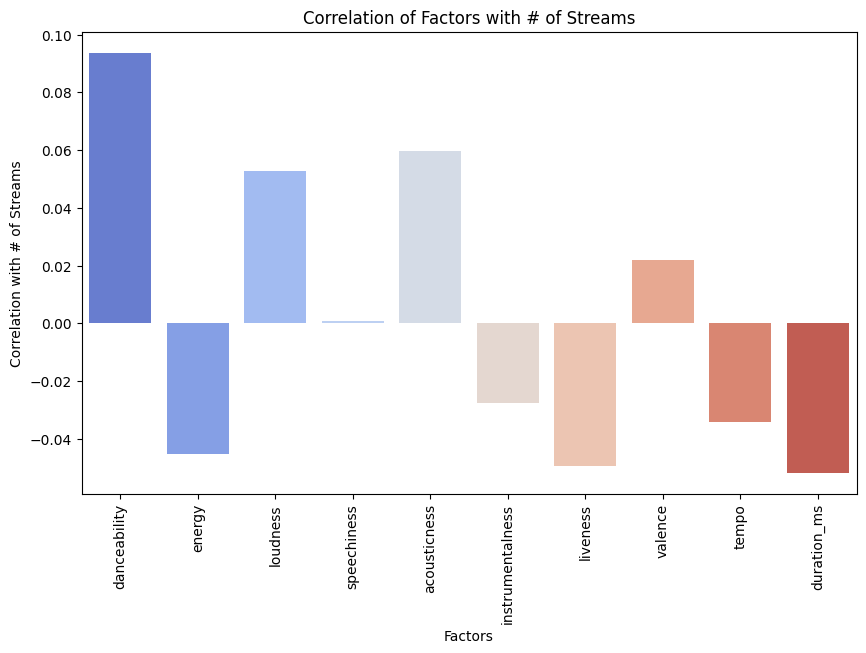

In [35]:
corr_matrix = important_df.corr()

# Extract the correlations with track popularity
popularity_corr = corr_matrix["Streams"].drop("Streams")

# Display the correlations
print(popularity_corr)

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(
    x=popularity_corr.index, y=popularity_corr.values, palette="coolwarm"
)
plt.xticks(rotation=90)
plt.xlabel("Factors")
plt.ylabel("Correlation with # of Streams")
plt.title("Correlation of Factors with # of Streams")
plt.show()

In [44]:
features = important_df.drop("Streams", axis=1)
labels = important_df["Streams"]

# One-hot encode categorical features if necessary
# features = pd.get_dummies(features)

# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, random_state=0
)

# Train a Decision Tree Regressor model

for i in range(50, 100, 5):
    model = RandomForestRegressor(random_state=42, max_depth=i)
    model.fit(features_train, labels_train)

    # Make predictions
    train_predictions = model.predict(features_train)
    test_predictions = model.predict(features_test)

    # Evaluate the model on training data
    train_mse = mean_squared_error(labels_train, train_predictions)
    train_r2 = r2_score(labels_train, train_predictions)
    print(f"Training Mean Squared Error: {train_mse}")
    print(f"Training R-squared: {train_r2}")

    # Evaluate the model on testing data
    test_mse = mean_squared_error(labels_test, test_predictions)
    test_r2 = r2_score(labels_test, test_predictions)
    print(f"Testing Mean Squared Error: {test_mse}")
    print(f"Testing R-squared: {test_r2}")

Training Mean Squared Error: 1.4796552820135992e+16
Training R-squared: 0.817371768872454
Testing Mean Squared Error: 5.543506323254786e+16
Testing R-squared: 0.28152175282742975
Training Mean Squared Error: 1.4796552820135992e+16
Training R-squared: 0.817371768872454
Testing Mean Squared Error: 5.543506323254786e+16
Testing R-squared: 0.28152175282742975
Training Mean Squared Error: 1.4796552820135992e+16
Training R-squared: 0.817371768872454
Testing Mean Squared Error: 5.543506323254786e+16
Testing R-squared: 0.28152175282742975
Training Mean Squared Error: 1.4796552820135992e+16
Training R-squared: 0.817371768872454
Testing Mean Squared Error: 5.543506323254786e+16
Testing R-squared: 0.28152175282742975
Training Mean Squared Error: 1.4796552820135992e+16
Training R-squared: 0.817371768872454
Testing Mean Squared Error: 5.543506323254786e+16
Testing R-squared: 0.28152175282742975
Training Mean Squared Error: 1.4796552820135992e+16
Training R-squared: 0.817371768872454
Testing Mean Sq